In [1]:
import os
import sys
import librosa
import tflearn
import pydub
import wave
import pickle
import speech_data
import segment_data
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline

#cur = os.getcwd()
#os.chdir('/home/cc/')
#import pyAudioAnalysis
#os.chdir(cur)

hdf5 not supported (please install/reinstall h5py)


/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# load constants - training directory, testing directory
training_data = '/home/cc/Data/Dev-Clean-Full/'
training = '/home/cc/Data/Dev-Clean-Train-Two/'
testing = '/home/cc/Data/Dev-Clean-Test-Two/'

In [3]:
# load one wav file to analyze, play it back
wav_file = os.listdir(training_data)[0]
y, sr = librosa.load(training_data + wav_file)
IPython.display.Audio(data=y, rate=sr)

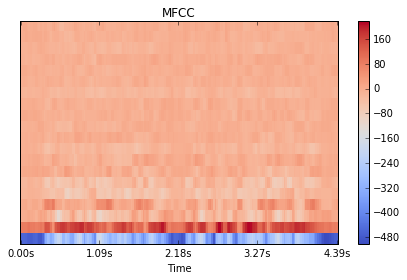

In [4]:
# perform mfcc calculation, display the result in graphic form
mfcc = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

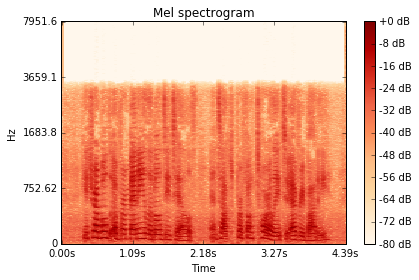

In [5]:
# additionally, display the mel-spectrogram of the audio file
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
D = librosa.stft(y)
S, phase = librosa.magphase(D)
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [6]:
# load the mfcc matrices via pickle:
X = pickle.load(open('/home/cc/Data/pickle_files/devfull_2secX.p', 'rb'))
Y = pickle.load(open('/home/cc/Data/pickle_files/devfull_2secY.p', 'rb'))
speakers = speech_data.get_speakers(training)

number of files: 5543
(40, ' speakers: ', ['Speaker36', 'Speaker28', 'Speaker29', 'Speaker20', 'Speaker21', 'Speaker22', 'Speaker23', 'Speaker24', 'Speaker25', 'Speaker26', 'Speaker27', 'Speaker1', 'Speaker0', 'Speaker3', 'Speaker2', 'Speaker5', 'Speaker4', 'Speaker7', 'Speaker6', 'Speaker9', 'Speaker8', 'Speaker13', 'Speaker34', 'Speaker11', 'Speaker15', 'Speaker14', 'Speaker37', 'Speaker10', 'Speaker35', 'Speaker12', 'Speaker33', 'Speaker32', 'Speaker31', 'Speaker30', 'Speaker19', 'Speaker18', 'Speaker16', 'Speaker39', 'Speaker38', 'Speaker17'])


In [7]:
'''
Now that this is calculated, do not need to run. Save for later use.

For now using to re-do the training-set and then testing set.

# calculate the mfcc matrices for training from the segmented data
X = []
Y = []
speakers = speech_data.get_speakers(training)
for f in os.listdir(training):
    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(training + f)
    X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
pickle.dump(X, open('/home/cc/Data/pickle_files/devfull_2secX.p', 'wb'))
pickle.dump(Y, open('/home/cc/Data/pickle_files/devfull_2secY.p', 'wb'))

'''

"\nNow that this is calculated, do not need to run. Save for later use.\n\nFor now using to re-do the training-set and then testing set.\n\n# calculate the mfcc matrices for training from the segmented data\nX = []\nY = []\nspeakers = speech_data.get_speakers(training)\nfor f in os.listdir(training):\n    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))\n    y, sr = librosa.load(training + f)\n    X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))\npickle.dump(X, open('/home/cc/Data/pickle_files/devfull_2secX.p', 'wb'))\npickle.dump(Y, open('/home/cc/Data/pickle_files/devfull_2secY.p', 'wb'))\n\n"

In [8]:
# define the network and the model for training
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)

net = tflearn.input_data(shape=[None, 20, 87])
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 128)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, len(speakers), activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

In [9]:
# now train the model!
model = tflearn.DNN(net)
model.fit(X, Y, n_epoch=500, show_metric=True, snapshot_step=1000, run_id='SpeakerRec')

Training Step: 43500  | total loss: 0.07550
| Adam | epoch: 500 | loss: 0.07550 - acc: 0.9774 -- iter: 5543/5543
Training Step: 43500  | total loss: 0.07550
| Adam | epoch: 500 | loss: 0.07550 - acc: 0.9774 -- iter: 5543/5543
--


In [25]:
# now test the model using the testing directory
testX = pickle.load(open('/home/cc/Data/pickle_files/devfull_2sectestX.p', 'rb'))
testY = pickle.load(open('/home/cc/Data/pickle_files/devfull_2sectestY.p', 'rb'))
#test = []
#for f in os.listdir(testing):
#    y, sr = librosa.load(testing + f)
#    test.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
result = model.predict(testX)
c = 0
for f,r in zip(os.listdir(testing), result):
    res = speech_data.one_hot_to_item(r, speakers)
    if res in f:
      #print('Actual: ' + f[:9] + '; Chosen: ' + res)
      c = c + 1
    else:
      print(c)
print(len(testY))
acc = float(c) / float(len(testX))
print('Test set accuracy: %s' %str(acc))

2
4
6
8
11
13
14
17
30
30
34
34
37
37
53
63
63
66
72
77
78
79
80
91
103
104
105
115
115
117
120
126
129
133
141
141
152
152
156
170
173
179
193
193
196
208
208
214
225
227
231
236
237
245
252
261
274
282
287
287
290
294
294
313
321
327
330
330
346
359
366
368
371
376
383
389
391
391
396
396
402
404
404
406
409
409
410
418
424
424
426
426
426
428
434
435
435
437
437
438
439
439
454
455
455
458
458
460
464
465
471
472
475
479
481
504
504
508
522
525
528
528
529
536
536
536
540
541
541
541
541
548
552
555
569
574
579
583
588
589
594
601
602
604
604
609
612
612
615
616
621
625
625
625
635
636
639
642
644
644
645
654
660
663
663
669
673
674
683
684
685
686
687
688
704
705
711
711
711
712
716
718
718
720
720
722
723
724
730
730
730
734
737
737
742
746
752
754
754
754
756
758
759
759
763
763
770
771
777
784
784
786
789
796
798
798
799
806
808
819
821
826
832
838
842
852
853
855
858
866
866
870
870
873
882
886
886
887
894
896
898
903
905
906
907
909
910
917
920
926
932
932
936
937
940
940
942


In [16]:
model.save('devfull.model')

INFO:tensorflow:./devfull.model is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'ConfigProto' object has no attribute 'name'


In [20]:
_y = model.predict(testX)